## 15. Transformer로 번역기 만들기

In [96]:
import tensorflow as tf
import pandas as pd
import numpy as np
import sentencepiece as spm

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

import os
import re
import random

In [4]:
# 한글 깨짐 방지
%config InlineBackend.figure_format = 'retina'
 
#mpl.font_manager.findfont(font)
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic')

### 1. 데이터 읽어오기

In [5]:
data_dir = os.getenv('HOME') + '/aiffel/transformer/data'
kor_text_path = data_dir + "/korean-english-park.train.ko"
eng_text_path = data_dir + "/korean-english-park.train.en"

In [6]:
# 데이터 읽어오기
def read_data(file_path):
    with open(file_path, "r") as f:
        raw = f.read().splitlines()

    print("Data Size:", len(raw))
    print("Example:")
    for sentence in raw[:5]:
        print(">>", sentence)

    return raw

In [48]:
kor_text = read_data(kor_text_path)
eng_text = read_data(eng_text_path)

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하지 않는다.
>> 그러나 이것은 또한 책상도 필요로 하지 않는다.
>> 79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분이든 그 움직임에따라 커서의 움직임을 조절하는 회전 운동 센서를 사용하고 있다.
>> 정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔음을 밝혔으며, 세계 해상 교역량의 거의 3분의 1을 운송하는 좁은 해로인 말라카 해협이 테러 공격을 당하기 쉽다고 경고하고 있다.
Data Size: 94123
Example:
>> Much of personal computing is about "can you top this?"
>> so a mention a few weeks ago about a rechargeable wireless optical mouse brought in another rechargeable, wireless mouse.
>> Like all optical mice, But it also doesn't need a desk.
>> uses gyroscopic sensors to control the cursor movement as you move your wrist, arm, whatever through the air.
>> Intelligence officials have revealed a spate of foiled plots on ships in Southeast Asia and are warning that a narrow stretch of water carrying almost one third of the world's maritime trade is vulnerable to a terror attack.


In [49]:
# 랜덤하게 문장을 추출하여 한영 번역 결과 확인
index = np.random.randint(len(kor_text))
print(kor_text[index])
print(eng_text[index])

식약청 연구소는 “이 약은 독극물이다”라고 밝혔다.
"It's a bottle of poison," the NAFDAC laboratory said.


In [50]:
# 문장 단위 텍스트 전처리
def preprocess_sentence(sentence):
    # 소문자 변환
    sentence = sentence.lower()

    # 문장 부호 간 띄어쓰기
    sentence = re.sub(r"([.,?!])", r" \1 ", sentence)
    
    # 숫자 간 띄어쓰기
    sentence = re.sub(r"([0-9]+)", r" \1 ", sentence)
    
    # 알파벳 한글 간 띄어쓰기
    sentence = re.sub(r"([a-zA-Z]+)", r" \1 ", sentence)

    # 알파벳, 한글, 숫자, 문장부호를 제외한 모든 문자를 공백으로 대체
    sentence = re.sub("[^a-zA-Z0-9가-힣.,?!]", " ", sentence)

    # 빈 칸 반복되는 것 하나로 줄이기
    sentence = re.sub(r'[" "]+', " ", sentence)

    # 문장 앞 뒤 공백 자르기
    sentence = sentence.strip()

    return sentence

In [51]:
# 데이터셋 단위 전처리
def preprocess_data(data):
    kor = []
    eng = []
    for k, e in zip(data['kor'], data['eng']):
        kor.append(preprocess_sentence(k))
        eng.append(preprocess_sentence(e))

    return kor, eng

In [54]:
# 정제된 말뭉치 만들기
# 한국어 텍스트, 영어 텍스트를 입력받아 젇제를 한 후 DataFrame으로 반환
def make_clean_corpus(kor_text, eng_text):
    # 데이터 크기가 다르면 경고를 출력하고 종료
    assert len(kor_text) == len(eng_text)

    # 데이터를 DataFrame으로 변환
    cleaned_corpus = pd.DataFrame({"kor": kor_text, "eng": eng_text})
    print(f'데이터 크기: {len(cleaned_corpus)}')

    # 중복 제거
    cleaned_corpus = data.drop_duplicates(subset=['kor'])
    print(f'중복 제거 후 데이터 크기: {len(cleaned_corpus)}')

    return cleaned_corpus

In [55]:
cleaned_corpus = make_clean_corpus(kor_text, eng_text)

데이터 크기: 94123
중복 제거 후 데이터 크기: 77591


In [40]:
cleaned_corpus.head()

,kor,eng
0,"개인용 컴퓨터 사용의 상당 부분은 ""이것보다 뛰어날 수 있느냐?""","Much of personal computing is about ""can you t..."
1,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...,so a mention a few weeks ago about a rechargea...
2,그러나 이것은 또한 책상도 필요로 하지 않는다.,"Like all optical mice, But it also doesn't nee..."
3,"79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분...",uses gyroscopic sensors to control the cursor ...
4,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔...,Intelligence officials have revealed a spate o...


### 2. SentencePiece 학습

In [56]:
# Sentencepiece를 활용하여 학습한 tokenizer를 생성합니다.
def generate_tokenizer(corpus, vocab_size, lang="ko", pad_id=0, bos_id=1, eos_id=2, unk_id=3):
    # 말뭉치를 파일로 저장
    temp_file = f'spm.train.{lang}.tmp'

    with open(temp_file, 'w') as f:
        for row in corpus:
            f.write(str(row) + '\n')

    # SentencePiece 학습
    spm.SentencePieceTrainer.Train(f'--input={temp_file} --model_prefix=spm_{lang} --vocab_size={vocab_size} --unk_id={unk_id} --bos_id={bos_id} --eos_id={eos_id} --pad_id={pad_id}')
    # --model_type = unigram이 디폴트 적용, --model_type = bpe로 변경 가능
    
    # 임시 파일 삭제
    if os.path.exists(temp_file):
        os.remove(temp_file)

    # 토크나이저 생성
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load(f'spm_{lang}.model')

    return tokenizer

In [73]:
# 문장 전처리
kor_corpus, eng_corpus = preprocess_data(cleaned_corpus)

In [74]:
# SentencePiece 학습
SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000

ko_tokenizer = generate_tokenizer(kor_corpus, SRC_VOCAB_SIZE, "ko")
en_tokenizer = generate_tokenizer(eng_corpus, TGT_VOCAB_SIZE, "en")
en_tokenizer.set_encode_extra_options("bos:eos")

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=spm.train.ko.tmp --model_prefix=spm_ko --vocab_size=20000 --unk_id=3 --bos_id=1 --eos_id=2 --pad_id=0
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: spm.train.ko.tmp
  input_format: 
  model_prefix: spm_ko
  model_type: UNIGRAM
  vocab_size: 20000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 3
  bos_id: 1
  eos_id: 2
  pad_id: 0
  unk_piece: <unk>
  b

True

In [75]:
# 결과 확인
!ls -l spm_*

-rw-r--r-- 1 root root 574314 Mar 10 05:57 spm_en.model
-rw-r--r-- 1 root root 354587 Mar 10 05:57 spm_en.vocab
-rw-r--r-- 1 root root 621625 Mar 10 05:56 spm_ko.model
-rw-r--r-- 1 root root 401445 Mar 10 05:56 spm_ko.vocab


In [76]:
# 토크나이저 테스트

# 문장 토큰화 결과 #1 - 띄어쓰기가 없는 문장 (한글)
print(ko_tokenizer.SampleEncodeAsPieces('아버지가방에들어가신다.', 1, 0.0))

# 문장 토큰화 결과 #2 -  학습에 사용한 문장 (한글)
print(ko_tokenizer.SampleEncodeAsPieces('로비스트에 휘둘린 부시 대통령은 위험한 방향으로 경제를 이끌고 있다.', 1, 0.0))

# 문장 토큰화 결과 #3 - 띄어쓰기가 없는 문장 (영어)
print(en_tokenizer.SampleEncodeAsPieces('Iamastudent.', 1, 0.0))

# 문장 토큰화 결과 #4 -  학습에 사용한 문장 (영어)
print(ko_tokenizer.SampleEncodeAsPieces("It's a bottle of poison.", 1, 0.0))

['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
['▁로비스트', '에', '▁휘둘', '린', '▁부시', '▁대통령은', '▁위험한', '▁방향으로', '▁경제', '를', '▁이끌', '고', '▁있다', '.']
['<s>', '▁', 'I', 'ama', 'st', 'udent', '.', '</s>']
['▁', 'I', 't', "'", 's', '▁a', '▁bo', 'tt', 'le', '▁of', '▁po', 'is', 'on', '.']


#### 디버깅
- 영어 문장의 경우 단어 단위로 토큰화가 되지 않음

In [ ]:
# 문장 리스트에 대해 토큰화
def sp_tokenize(tokenizer, corpus): 
    tensor = []

    for sentence in corpus:
        try:
            tensor.append(tokenizer.EncodeAsIds(sentence))
        except:
            print(sentence)

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre')

    return tensor, word_index, index_word

In [ ]:
# 학습/테스트 데이터 토큰화
train_x, word_index_train, index_word_train = sp_tokenize(tokenizer, train_data['document'])
test_x, word_index_test, index_word_test = sp_tokenize(tokenizer, test_data['document'])

In [78]:
from tqdm.notebook import tqdm    # Process 과정을 보기 위해

src_corpus = []
tgt_corpus = []

assert len(kor_corpus) == len(eng_corpus)

# 토큰의 길이가 50 이하인 문장만 남깁니다. 
for idx in tqdm(range(len(kor_corpus))):
    tokens = ko_tokenizer.EncodeAsIds(kor_corpus[idx])
    if len(tokens) < 50:
        src_corpus.append(tokens)
        tgt_corpus.append(en_tokenizer.EncodeAsIds(eng_corpus[idx]))

# 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

  0%|          | 0/77591 [00:00<?, ?it/s]

In [111]:
print(enc_train.shape, dec_train.shape)

(75036, 49) (75036, 113)


In [112]:
print(dec_train[0])

[   1  362   11 1418 7545   14   24   54  110  109  259   50   16    3
    2    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0]


### 3. Trasformer 모델

In [124]:
# 포시셔널 인코딩
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    print(pos, d_model)
    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table

In [206]:
# 멀티헤드 어텐션
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        self.depth = d_model // self.num_heads

        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)

        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)
        #print(f'scaled_qk: {scaled_qk.shape}, mask: {mask.shape}')

        if mask is not None: scaled_qk += (mask * -1e9)

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions


    def split_heads(self, x):
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

        return combined_x


    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)

        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)

        out, attention_weights = self.scaled_dot_product_attention(WQ_splits, WK_splits, WV_splits, mask)

        out = self.combine_heads(out)
        out = self.linear(out)

        return out, attention_weights

In [180]:
# 피드 포워드
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)

        return out

In [181]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)

    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual

        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, enc_attn

In [182]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)

    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        #out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out, dec_attn = self.dec_self_attn(out, out, out, causality_mask)
        out = self.dropout(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        #out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, padding_mask)
        out = self.dropout(out)
        out += residual

        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [183]:
class Encoder(tf.keras.Model):
    def __init__(self, n_layers, d_model, n_heads, d_ff, dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)]

    def call(self, x, mask):
        out = x

        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)

        return out, enc_attns

In [184]:
class Decoder(tf.keras.Model):
    def __init__(self, n_layers, d_model, n_heads, d_ff, dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)]

    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x

        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

In [185]:
class Transformer(tf.keras.Model):
    def __init__(self, n_layers, d_model, n_heads, d_ff, src_vocab_size, tgt_vocab_size, pos_len, dropout=0.2, shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        """
        1. Embedding Layer 정의
        2. Positional Encoding 정의
        3. Encoder / Decoder 정의
        4. Output Linear 정의
        5. Shared Weights
        6. Dropout 정의
        """
        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        """
        입력된 정수 배열을 Embedding + Pos Encoding
        + Shared일 경우 Scaling 작업 포함

        x: [ batch x length ]
        return: [ batch x length x emb ]
        """
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared:
            out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out

    def call(self, enc_in, dec_in, enc_padding_mask, dec_causality_mask, dec_padding_mask):
        """
        아래 순서에 따라 소스를 작성하세요.

        Step 1: Embedding(enc_in, dec_in) -> enc_in, dec_in
        Step 2: Encoder(enc_in, enc_mask) -> enc_out, enc_attns
        Step 3: Decoder(dec_in, enc_out, mask)
                -> dec_out, dec_attns, dec_enc_attns
        Step 4: Out Linear(dec_out) -> logits
        """
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_padding_mask)

        dec_out, dec_attns, dec_enc_attns = self.decoder(dec_in, enc_out, dec_causality_mask, dec_padding_mask)

        logits = self.fc(dec_out)

        return logits, enc_attns, dec_attns, dec_enc_attns

In [186]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

In [187]:
def generate_causality_mask(size):
    #print ("here 5", size)
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    #print ("here 6", mask)
    return mask  # (seq_len, seq_len)

In [209]:
def generate_masks(src, tgt):
    #enc_mask = generate_padding_mask(src)
    enc_padding_mask = generate_padding_mask(src)

    #ec_mask = generate_causality_mask(tgt.shape[1])
    dec_cauality_mask = generate_causality_mask(tgt.shape[1])

    #ec_enc_mask = generate_padding_mask(tgt)
    #dec_padding_mask = generate_padding_mask(tgt)
    dec_padding_mask = generate_padding_mask(src)

    #print(f'enc_padding_mask: {enc_padding_mask.shape}, dec_cauality_mask: {dec_cauality_mask.shape}, dec_padding_mask: {dec_padding_mask.shape}')
    return enc_padding_mask, dec_cauality_mask, dec_padding_mask

enc_padding_mask: (16, 1, 1, 25), dec_cauality_mask: (35, 35), dec_padding_mask: (16, 1, 1, 35)
(16, 1, 1, 35)


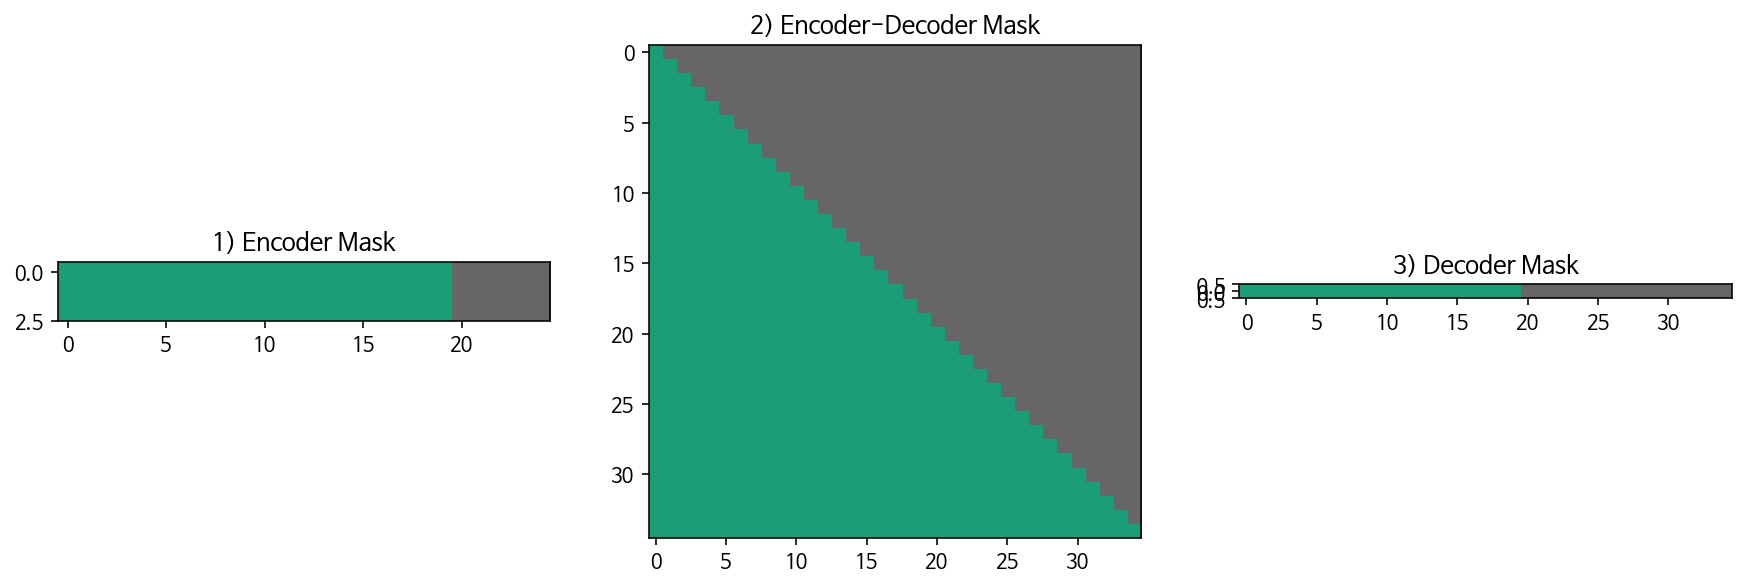

In [195]:
batch, length = 16, 20
src_padding = 5
tgt_padding = 15

src_pad = tf.zeros(shape=(batch, src_padding))
tgt_pad = tf.zeros(shape=(batch, tgt_padding))

sample_data = tf.ones(shape=(batch, length))

sample_src = tf.concat([sample_data, src_pad], axis=-1)
sample_tgt = tf.concat([sample_data, tgt_pad], axis=-1)

enc_mask, dec_enc_mask, dec_mask = generate_masks(sample_src, sample_tgt)
print(dec_mask.shape)
fig = plt.figure(figsize=(15, 15))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title('1) Encoder Mask')
ax2.set_title('2) Encoder-Decoder Mask')
ax3.set_title('3) Decoder Mask')

ax1.imshow(enc_mask[:3, 0, 0].numpy(), cmap='Dark2')
#ax2.imshow(dec_enc_mask[0, 0].numpy(), cmap='Dark2')
ax2.imshow(dec_enc_mask.numpy(), cmap='Dark2')
ax3.imshow(dec_mask[0, 0].numpy(), cmap='Dark2')
#ax3.imshow(dec_mask.numpy(), cmap='Dark2')

plt.show()


In [ ]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)

        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

In [199]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [210]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]

    #print(src, tgt)
    enc_padding_mask, dec_cauality_mask, dec_padding_mask = generate_masks(src, tgt)
    #print(enc_mask)
    #print(dec_enc_mask)
    #print(dec_mask)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = model(src, tgt, enc_padding_mask, dec_cauality_mask, dec_padding_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    # [[YOUR CODE]]
    #grads = tape.gradient(loss)
    #optimizer.apply_gradients(grads)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns

In [191]:
# Attention 시각화 함수
def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, square=True, vmin=0.0, vmax=1.0, cbar=False, ax=ax, xticklabels=x, yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [192]:
# 번역 생성 함수
def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens], maxlen=enc_train.shape[-1], padding='post')
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns = model(_input, output, enc_padding_mask, combined_mask, dec_padding_mask)

        predicted_id = tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [193]:
# 번역 생성 및 Attention 시각화 결합
def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

In [ ]:
# 학습
from tqdm import tqdm_notebook 

BATCH_SIZE = 64
EPOCHS = 20

NUM_LAYER = 1
DIM_MODEL = 512
NUM_HEAD = 8
DIM_FF = 512

# 포지셔널 인코딩을 계산할 길이. 미리 계산되는 값이며, 인코더 시퀀스, 디코더 시퀀스보다 커야 함
POSITIONAL_ECODING_LENGTH = 150

examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."
]

transformer = Transformer(NUM_LAYER, DIM_MODEL, NUM_HEAD, DIM_FF, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, POSITIONAL_ECODING_LENGTH)

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        #print(batch, idx, idx+BATCH_SIZE)
        #print(enc_train[idx:idx+BATCH_SIZE].shape, dec_train[idx:idx+BATCH_SIZE].shape)
        batch_loss, enc_attns, dec_attns, dec_enc_attns = train_step(enc_train[idx:idx+BATCH_SIZE], dec_train[idx:idx+BATCH_SIZE], transformer, optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    for example in examples:
        translate(example, transformer, ko_tokenizer, en_tokenizer)

150 512


/tmp/ipykernel_40/1556860544.py:29: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm_notebook(idx_list)


  0%|          | 0/1173 [00:00<?, ?it/s]